# Training a Classifier to Detect Homophobic Speech

Note: please ignore the In [x] symbols on the left side.  This has been edited to be readable from other notebooks

In [1]:
#install everything you need
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from IPython.display import display,HTML
from fastai.text.all import *

In [61]:
# create the path object to the IMDB text files
path = untar_data(URLs.IMDB)

### Language Model Using DataBlock

In [62]:
# Create data loaders object from text files in folders. For language model training

get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=64, seq_len=40)

In [ ]:
# Save the Data Loaders object so you can reuse later or in another application
torch.save(dls_lm,'dls_lm_imdb.pkl')

#to reload simply dls_lm = torch.load('dls_lm_imdb.pkl')

In [63]:
# Show what's in the dataloaders 
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos i came into the cinema already having seen the trailer not expecting much from the movie . xxmaj the first 45 minutes were xxup ok starting with a few funny lines and getting a taster of what was to,i came into the cinema already having seen the trailer not expecting much from the movie . xxmaj the first 45 minutes were xxup ok starting with a few funny lines and getting a taster of what was to come
1,"never lets us find out exactly what 's wrong with xxmaj myrtle , and despite her coming through in the end , there 's no reason to expect that she has really resolved anything of consequence . xxmaj this sort","lets us find out exactly what 's wrong with xxmaj myrtle , and despite her coming through in the end , there 's no reason to expect that she has really resolved anything of consequence . xxmaj this sort of"


### Fine-Tuning the Language Model

In [66]:
# instantiate a learner
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [52]:
'''optional: If you already have a trained model, load it'''
# learn.path = Path('/notebooks/clean') # change the path
# learn = learn.load('1epoch_imdb') # load the already existant model

SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=6.309573450380412e-07)

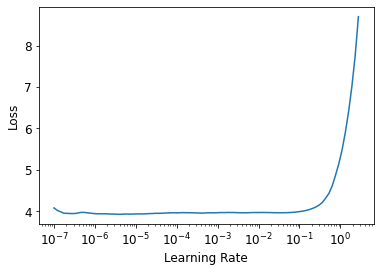

In [9]:
# run lr_find to check your learning rate
learn.lr_find()

In [10]:
# train on one cycle to see how accurate you can get
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.036342,3.956240,0.297208,52.260441,1:46:08


         ... As you can see the model takes 1hr 46m to train so what you see here is my second training the next day after training the first model

In [11]:
#save the full model that you've trained
learn.save('2epoch_imdb')

Path('/notebooks/clean/models/2epoch_imdb.pth')

In [ ]:
# save the encoder of the model for later classification training
learn.save_encoder('2epoch_imdb_e')

In [ ]:
# if you have time, run 10 more epochs...I didn't...yet
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

### Text Generation

In [85]:
# type in random text to see what your model spits out for fun:
TEXT = "All countries are wonderful."
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [86]:
# print out what the model predicts comes next from starting the sentence "All countries are wonderful."
print("\n".join(preds)) 

all countries are wonderful . The North American Film Institute has called it " one of the most successful and lumieres American films of the last 20 years " . In 2008 , Edward D.
all countries are wonderful . For example , two movies that made Luckily Look Dirty Face are Dirty Diana and The Growing Storm . The other two are The Big Bang


## From LM to Classifier

### Balance Your Classifier Dataset: Resampling

Duplicate the homophobic texts from your df so that they are closer to the same amount as your non-homophobic texts.  This should help you dataset work a little better. See this article by [Jason Brownlee](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

In [ ]:
# create your list of words to find
insults = ['''insert keywords here''']

# create your conditions for everything
cond = (k.identity_hate==1) & (k.comment_text.str.lower().str.contains('|'.join(o for o in insults)))

# create the column and place with either a 1 or a zero 
k['homp'] = np.where(cond, 1,0)

abh = k[k.any_bad == 1]
abh = abh[['comment_text', 'homp']]
len(abh)

In [ ]:
# balance the data by adding 26x homp ==1.  abh has now goes from 16k rows to 31k rows

new_df = abh[ abh['homp'] > 0 ] #create df of what you want to duplicate

#multiply it times 26 and append it to the original
abh = abh.append( [new_df] * 26, ignore_index=True) 

In [8]:
# Save your work
df.to_csv('homp_allbad_balanced.csv')

### Creating the Classifier DataLoaders

In [30]:
# create classifier dataloaders from df
dls_clas = TextDataLoaders.from_df(df, path=path, valid_pct=0.2, vocab=dls_lm.vocab,
                                   text_col='comment_text', label_col='label',)
dls_clas.show_batch(max_n=3)

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,category
0,xxbos xxmaj take that ! \n\n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass,0
1,xxbos xxup fuck xxup your xxup dog \n\n xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your xxup dog xxup fuck xxup your,0
2,"xxbos xxup lmao xxup what xxup weak xxup threats , i xxup have nt xxup been xxup banned xxup yet xxup bitch , xxup go xxup vandalism xxup lmao xxup what xxup weak xxup threats , i xxup have nt xxup been xxup banned xxup yet xxup bitch , xxup go xxup vandalism xxup lmao xxup what xxup weak xxup threats , i xxup have nt xxup been xxup banned xxup yet xxup bitch , xxup go xxup vandalism xxup lmao xxup what xxup weak xxup threats , i xxup have nt xxup been xxup banned xxup yet xxup bitch , xxup go xxup vandalism xxup lmao xxup what xxup weak xxup threats , i xxup have nt xxup been xxup banned xxup yet xxup bitch , xxup go xxup vandalism xxup lmao xxup what xxup weak xxup threats , i xxup have nt xxup been xxup banned xxup yet",0


... I'm not showing the batches here because it's not very nice stuff.

In [31]:
# save your clasafying dataloaders
torch.save(dls_clas,'dls_clas_imdb.pkl')

#to reload
# dls_clas = torch.load('dls_clas_imdb.pkl')

In [26]:
# align save the dls_lm.vocab to be tthe same as the classifier vocab
dls_clas.vocab=dls_lm.vocab

In [27]:
# instantiate a text_classifier_learner with the dls_clas
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

### Fine-Tuning the Classifier

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.002511886414140463)

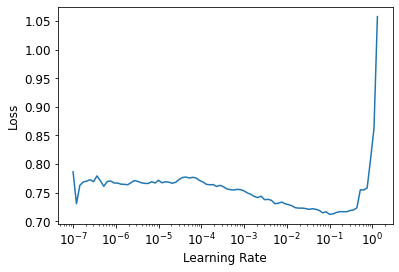

In [32]:
# Find the optimal learning rate
learn.lr_find()

In [33]:
# Run one cycle at the learning rate you decided
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.543905,0.454791,0.787759,00:31


Train the encoder only unfreezing one layer at a time

In [34]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.263638,0.128063,0.954294,00:35


In [35]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.091682,0.036577,0.990827,00:51


In [40]:
#  Save the best model
learn.save('clas_1epoch_imdbtokag_n3_9908')

Path('/notebooks/clean/models/clas_1epoch_imdbtokag_n3_9908.pth')

In [ ]:
# Save the encoder to be trained on other data sets
learn.save_encoder('clas_1epoch_imdb_n3_e')

In [42]:
learn.load('clas_1epoch_imdbtokag_n3_9908')

In [41]:
# Attempted to run, but did not save this because it began to overfit and became less accurate
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.054417,0.039059,0.988613,01:09


In [48]:
# test out how good the model is at predicting something you copy and paste from another website
learn.predict('It\'s been really nice to see how much public discourse has changed since Michael Sam came out in 2014. At the time it was reasonable to say something like "a team might not want to draft him because it\'ll cause a lot of unnecessary controversy and drama". All the reaction I\'ve seen to Carl Nassib coming out has been overwhelmingly supportive. This makes me quite optimistic for the future and happy for the progress we\'ve made.')

('1', tensor(1), tensor([0.1273, 0.8727]))

above, 1 is homophobic and 0 is non-homophobic.  Beware: this is purposely trained so that hate speech against other groups is not listed as homophobic though it might be extreemly inapproriate.  

### The more you test out the predictor, the more you will see this model is not very good at predicting outside the dataset.  I will update here when I've transfered the model to other data sets.